# Fine Tuning Bert Model

https://github.com/prateekjoshi565/Fine-Tuning-BERT

In [ ]:
import os
os.environ["TORCH_HOME"]="./torch"

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset

In [ ]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print("*"*30)
print("SPAM")
print("*"*30)
for i in range(5):
    print(i+1, "-", df.loc[df["label"]==1]["text"].tolist()[i])
    print()

print("*"*30)
print("HAM")
print("*"*30)
for i in range(5):
    print(i+1, "-", df.loc[df["label"]==0]["text"].tolist()[i])
    print()

******************************
SPAM
******************************
1 - Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

2 - FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

3 - WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.

4 - Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030

5 - SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info

******************************
HAM
******************************
1 - Go until jurong point, crazy.. Available only in bugis n great world la e buffet..

In [ ]:
print("Number of sentences =", df.shape[0])

Number of sentences = 5572


In [ ]:
print("Label 0 Num :",(df["label"]==0).sum())
print("Label 1 Num :",(df["label"]==1).sum())

# check class distribution
df['label'].value_counts(normalize = True)

Label 0 Num : 4825
Label 1 Num : 747


,proportion
label,
0,0.865937
1,0.134063


# Split train dataset into train, validation and test sets

## D -> [A, B] -> [A, B', B'']
## A = Train
## B' = Val
## B'' = Test

In [ ]:

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
tokenizer.convert_ids_to_tokens(2023)

'this'

In [ ]:
for i in sent_id["input_ids"]:
    for word in i:
        print(word, "-", tokenizer.convert_ids_to_tokens(word))

101 - [CLS]
2023 - this
2003 - is
1037 - a
14324 - bert
2944 - model
14924 - tutor
4818 - ##ial
102 - [SEP]
0 - [PAD]
101 - [CLS]
2057 - we
2097 - will
2986 - fine
1011 - -
8694 - tune
1037 - a
14324 - bert
2944 - model
102 - [SEP]


### SIMPLE DEMO OF BPE

In [ ]:
print("TRAIN VOCAB")
print("*"*20)
print("insufficient")
print("insane")
print("incomplete")
print("appropriate")
print()
print("TEST VOCAB")
print("*"*20)
print("inappropriate")
print("in")
print("##appropriate")

#UNK = UNKNOWN

TRAIN VOCAB
********************
insufficient
insane
incomplete
appropriate

TEST VOCAB
********************
inappropriate
in
##appropriate


# Tokenization

<Axes: >

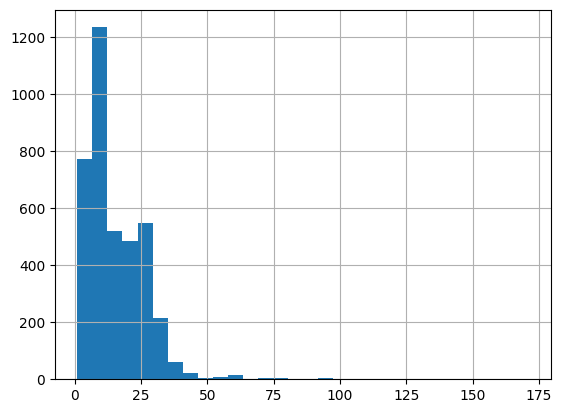

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 80

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2) # HAM vs SPAM (2 LABELS)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)
#         print(cls_hs)
#         x = self.fc1(outputs.last_hidden_state)
        x = self.fc1(outputs.pooler_output)
        #x dim 512
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
print(model)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes =np.unique(train_labels), y=train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
batch = next(iter(train_dataloader))
batch = [r.to(device) for r in batch]

sent_id, mask, labels = batch

In [ ]:
out = model.bert(sent_id, mask)

In [ ]:
out[0].size()

torch.Size([32, 80, 768])

In [ ]:
out[1].size()

torch.Size([32, 768])

In [ ]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
#         print(sent_id)
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
#         print(preds.size(/))
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward() #GRADIENT

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval() #DROP OUT

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

          # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

          # model predictions
            preds = model(sent_id, mask)

          # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(10):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("SAVING MODEL")
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.660
Validation Loss: 0.622

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.607
Validation Loss: 0.572

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.559
Validation Loss: 0.522

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.518
Validation Loss: 0.477

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.483
Validation Loss: 0.444

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.453
Validation Loss: 0.414

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...
SAVING MODEL

Training Loss: 0.426
Validation Loss: 0.385

 Epoch 8 / 10
  Bat

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-35-5a29cc8ec3f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
    model.eval()
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
test_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
preds

array([[-0.66901946, -0.71787155],
       [-0.3172984 , -1.3023702 ],
       [-1.3946514 , -0.28491184],
       ...,
       [-1.6313746 , -0.21773382],
       [-0.23790048, -1.552496  ],
       [-0.20230034, -1.6974475 ]], dtype=float32)

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       724
           1       0.54      0.88      0.67       112

    accuracy                           0.88       836
   macro avg       0.76      0.88      0.80       836
weighted avg       0.92      0.88      0.89       836



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,639,85
1,13,99


In [ ]:
import math
labels = ["HAM", "SPAM"]
while True:
    input_sentence = input("Try a sentence :")
    tokens = tokenizer.batch_encode_plus(
        [input_sentence],
        max_length = max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )
    input_ids= torch.tensor(tokens['input_ids'])
    attention_mask= torch.tensor(tokens['attention_mask'])
    preds = model(input_ids.to(device), attention_mask.to(device))
    probs = preds.detach().cpu().numpy()
    preds = np.argmax(probs[0])
    print(f"The input sentence is predicted to be {labels[int(preds)]} with {round(math.exp(probs[0][int(preds)]),2)} probability")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')